In [1]:
# all imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard




2024-07-09 16:36:31.424844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 16:36:31.424989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 16:36:31.568610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')

########################################################################################

# print(TEST_IMG)
# print(TRAIN_IMG)
# print(TRAIN_DATASE_CSV)

In [3]:
# get train/test image list
train_imgs = os.listdir(TRAIN_IMG_DIR)
test_imgs = os.listdir(TEST_IMG_DIR)

# print(f"{train_imgs[:10]}")
# print(f"{test_imgs[:10]}")

In [4]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)
df_backup = df

# add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# add info about total number of ships at the image
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# concat all EncodedPixels into AllEncodedPixels
df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
    lambda x: np.nan if x.isna().all() else ' '.join(filter(None, x))
)

# remove repeating images
df = df.drop_duplicates(subset='ImageId', keep='first')

# delete EncodedPixels column
df = df.drop(columns=['EncodedPixels'])

# reset indexes
df = df.reset_index(drop=True)


df.head()


,ImageId,has_ship,ship_count,AllEncodedPixels
0,00003e153.jpg,0,0,NaN
1,0001124c7.jpg,0,0,NaN
2,000155de5.jpg,1,1,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,1,5,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,0,0,NaN


In [5]:
# check the results of the previous operations

tst = df[df['ImageId'] == '000194a2d.jpg']['AllEncodedPixels'].tolist()
print(tst)

['360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165 9 368933 10 369702 10 370471 9 371240 9 372009 9 372777 10 373546 9 374315 9 375084 7 375852 6 376621 3 377390 1 51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 61050 9 61818 9 62586 9 63354 9 64122 9 64890 9 198320 10 199088 10 199856 10 200624 10 201392 10 202160 10 202928 10 203696 10 204464 10 205232 10 206000 10 206768 10 207536 10 208304 10 209072 10 209840 10 210608 10 211376 10 212144 10 212912 10 213680 10 214448 10 215216 10 215984 10 216751 10 217519 10 218287 10 219055 10 219823 10 220591 10 221359 10 222127 10 222895 10 223663 10 224431 10 225199 10 225967 10 226735 10 227503 10 228271 10 229039 10 229807 10 230575 10 231343 10 232111 10 232879 10 233647 10 234415 10 55683 1 56451 1 57219 1 57987 1 58755 1 59523 1 60291 1 254389 9 255157 17 255925 17 256693 17 257461 17 258229 17 258997 17 259765 17 260533 17 261301 17 26206

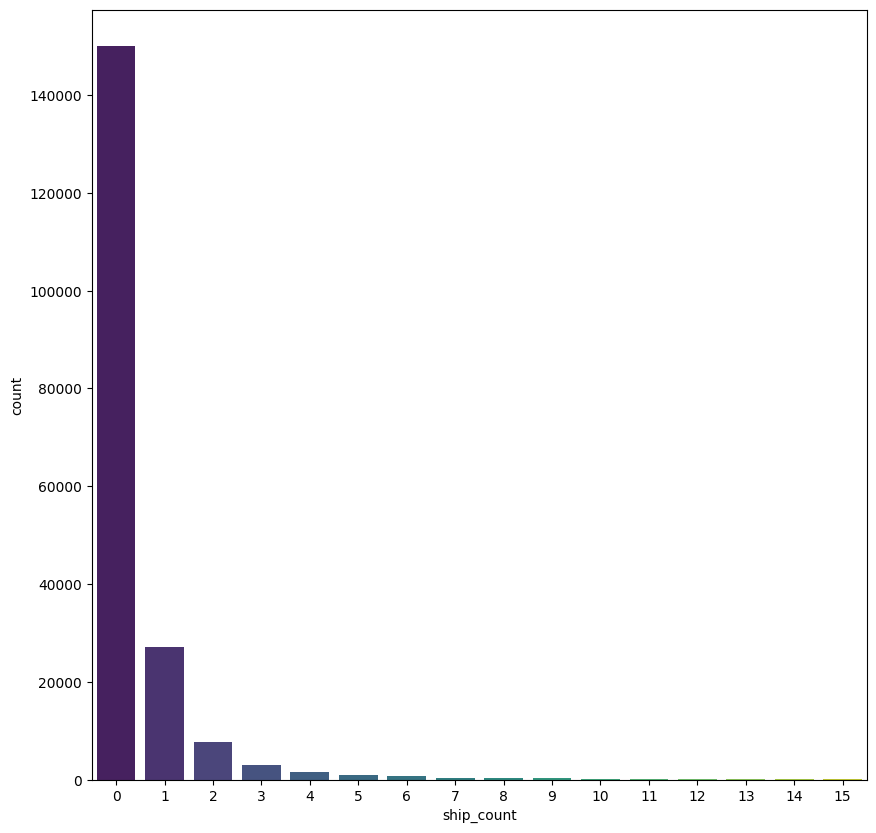

In [6]:
# check distribution of ship_count per image
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=df, palette='viridis')
plt.show()

In [7]:

value_counts = df['ship_count'].value_counts()
print(value_counts)


ship_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64


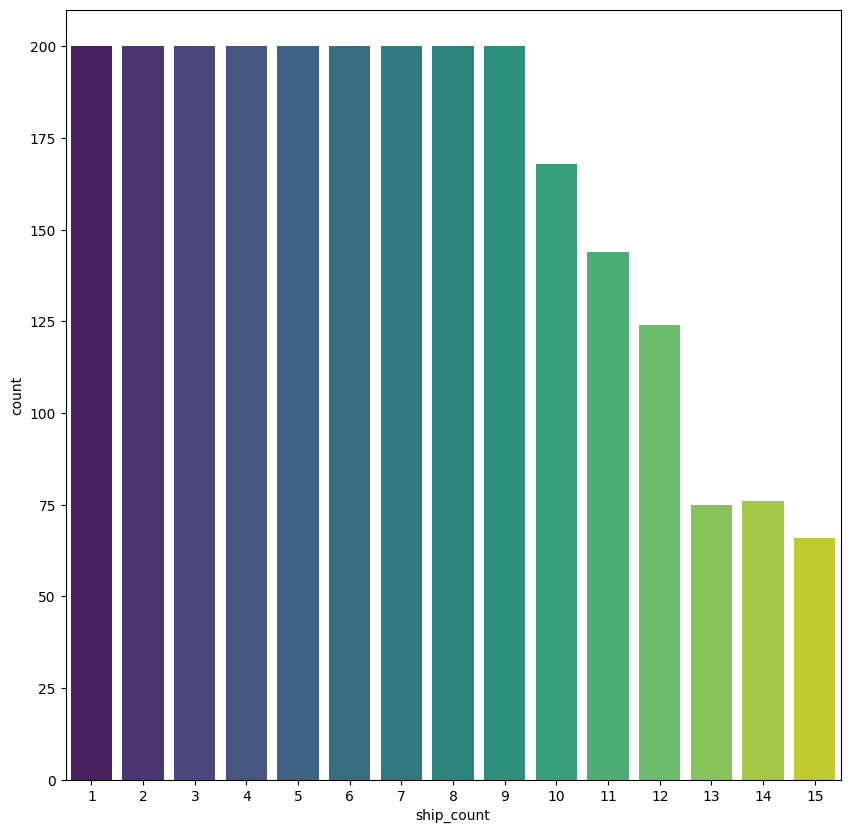

In [8]:
# balance dataset
NUM_SAMPLES = 200
# NUM_SAMPLES = value_counts.min()

balanced_df = pd.DataFrame()

for value in value_counts.index:
    subset = df[df['ship_count'] == value]
    number_samples = NUM_SAMPLES if NUM_SAMPLES < len(subset) else len(subset)
#     print(f"subset len - {len(subset)}")
    resampled_subset = resample(subset, replace=False, n_samples=number_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_subset])

# drop images with less than 10 ships

balanced_df = balanced_df[balanced_df['ship_count'] >= 1]

    
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=balanced_df, palette='viridis')
plt.show()


In [9]:
# split train data into train and validation
train_ids, validation_ids = train_test_split(
    balanced_df, test_size = 0.2, stratify = balanced_df['ship_count'])

train_df = pd.merge(balanced_df, train_ids)
validation_df = pd.merge(balanced_df, validation_ids)

print(f"train_df:\n {train_df.sample(5)}")
print(f"validation_df:\n {validation_df.sample(5)}")

train_df:
             ImageId  has_ship  ship_count  \
1924  4de149bd9.jpg         1          15   
952   9a1c6fd32.jpg         1           6   
1779  fb33f4eb1.jpg         1          12   
899   b21940557.jpg         1           6   
738   505558800.jpg         1           5   

                                       AllEncodedPixels  
1924  517904 1 518671 3 519438 5 520205 7 520972 9 5...  
952   299988 2 300756 4 301523 6 302291 6 303058 6 3...  
1779  501636 4 502405 3 503173 3 503941 3 504709 3 5...  
899   309786 2 310552 4 311317 8 312083 10 312849 13...  
738   471314 1 472081 4 472849 5 473616 8 474383 10 ...  
validation_df:
            ImageId  has_ship  ship_count  \
185  72e5ce016.jpg         1           5   
447  dd831daba.jpg         1          12   
417  e61c88e3b.jpg         1          11   
99   3b1873681.jpg         1           3   
266  51469b425.jpg         1           7   

                                      AllEncodedPixels  
185  395098 2 395864 4 396632 5 

In [10]:
#utility functions
def rle_to_mask(starts, lengths, height, width):
    # Create an empty array of zeros of shape (height, width)
    mask = np.zeros(height * width, dtype=np.uint8)
    
    # For each start and length, set the corresponding values in the mask to 1
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    
    # Reshape the mask into the desired dimensions
    mask = mask.reshape((height, width))
    mask = mask.T
    return mask

def create_mask(mask_array, width=768, height=768):
    masks = np.zeros((width, height), dtype=np.int16)
    # if element == element:
    if isinstance(mask_array, str):
        split = mask_array.split()
        # print(split)
        startP, lengthP = [np.array(x, dtype=int) for x in (split[::2], split[1::2])]
        masks += (rle_to_mask(startP, lengthP, width, height))
    return masks

In [11]:
# image generator
BATCH_SIZE = 4

def img_gen(input_df, batch_size = BATCH_SIZE):
    # shuffle the dataset
    input_df = input_df.sample(frac=1, random_state=42).reset_index(drop=True)
#     print(input_df.head())
    out_rgb = []
    out_mask = []
    i = 1
    while True:
        for index, row in input_df.iterrows():
            rgb_path = os.path.join(TRAIN_IMG_DIR, row.ImageId)
            rgb = Image.open(rgb_path)
            rgb = np.array(rgb)/255.0
            mask = create_mask(row.AllEncodedPixels)
            mask = np.expand_dims(mask, -1)
#             print(f"mask shape {mask.shape}")
#             print(f"rgb shape {rgb.shape}")
            out_rgb += [rgb]
            out_mask += [mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0), np.stack(out_mask, 0).astype(np.float32)
                out_rgb, out_mask=[], []

# for index, row in df.iterrows():
# img_gen(train_df)

In [12]:
train_gen = img_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0.0 1.0


In [13]:
# create validation set
VALIDATION_SET_SIZE = 100

validation_x, validation_y = next(img_gen(validation_df, VALIDATION_SET_SIZE))

In [14]:
# data augmentation

# arhuments for augmentation image generator
data_gen_args = dict(rotation_range = 90,
                       horizontal_flip = True,
                       vertical_flip = True,
                       data_format = 'channels_last')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def augmentation_generator(input_gen, seed = None):
    random_seed = np.random.randint(0, 10000)
    for input_x, input_y in input_gen:
        augmented_x = image_datagen.flow(
            input_x*255,
            batch_size=input_x.shape[0],
            seed=random_seed
        )

        augmented_y = mask_datagen.flow(
            input_y,
            batch_size=input_y.shape[0],
            seed=random_seed
        )

        yield next(augmented_x)/255.0, next(augmented_y)


In [15]:
model_fit_gen = augmentation_generator(train_gen)

# train_gen = augmentation_generator(train_gen)
# t_x, t_y = next(model_fit_gen)
# print('x', t_x[0].shape, t_x.dtype, t_x.min(), t_x.max())
# print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

In [16]:
# model

def unet(input_shape, optimizer, loss, metrics):
    inputs = Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = layers.MaxPooling2D((2, 2)) (c4)

    # Bottleneck
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    # Decoder
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


# input_shape = (768, 768, 3)
# model = unet(input_shape)
# model.summary()



In [17]:
# loss functions
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3]  )
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


def dice_loss(y_true, y_pred):
    return 1 - dice_score(y_true, y_pred)


In [18]:
# callbacks


tensorboard = TensorBoard(log_dir='logs')

earlystopping = EarlyStopping(
    monitor="val_dice_score", 
    mode="max", 
    patience=50) 

checkpoint = ModelCheckpoint(
    filepath='model.{epoch:02d}-{val_loss:.2f}.weights.h5',
    monitor='val_dice_score',
    verbose=1,
    mode='max',
    save_weights_only = True)


callbacks = [tensorboard, earlystopping, checkpoint]

In [19]:
# train model
# TODO
INPUT_DATA_DIM = (768,768,3)
BATCH_SIZE = 40
STEP_COUNT = train_df.shape[0]//BATCH_SIZE
NB_EPOCHS = 100

print(f"train_df.shape[0] - {train_df.shape[0]}")
print(f"STEP COUNT - {STEP_COUNT}")

model = unet(INPUT_DATA_DIM, optimizer='adam', loss=dice_loss, metrics=[dice_score])
model.summary()


train_df.shape[0] - 1962
STEP COUNT - 49


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 768, 768,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 768, 768,  │        224 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 768, 768,  │        584 │ conv2d[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 384, 384,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 384, 384,  │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 384, 384,  │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 192, 192,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 192, 192,  │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 192, 192,  │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 96, 96,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 96, 96,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 96, 96,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 48, 48,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 48,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 48, 48,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 96, 96,    │     32,832 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96, 96,    │          0 │ conv2d_transpose

 Total params: 485,817 (1.85 MB)

 Trainable params: 485,817 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_fit_gen = augmentation_generator(img_gen(train_df, BATCH_SIZE))
# x, y = next(model_fit_gen)
# print(f"x.shape - {x.shape}")
# print(f"validation_x.shape - {validation_x.shape}")

In [ ]:
model.fit(
    model_fit_gen,
    steps_per_epoch=STEP_COUNT,
    epochs=NB_EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=callbacks)

Epoch 1/100


2024-07-09 16:37:52.186511: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[40,8,768,768]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,3,768,768]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-09 16:37:52.562942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.78083, expected 2.84258
2024-07-09 16:37:52.562998: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.66447, expected 4.72622
2024-07-09 16:37:52.563007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.40875, expected 4.47051
2024-07-09 16:37:52.563015: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Diff

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - dice_score: 0.0190 - loss: 0.9810

2024-07-09 16:46:05.895992: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,8,768,768]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,768,768]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-09 16:46:05.982759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.48343, expected 2.67507
2024-07-09 16:46:05.982807: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.61589, expected 4.80753
2024-07-09 16:46:05.982817: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.97192, expected 4.16356
2024-07-09 16:46:05.982825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Diff


Epoch 1: saving model to model.01-0.79.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 557s 9s/step - dice_score: 0.0194 - loss: 0.9806 - val_dice_score: 0.2547 - val_loss: 0.7898
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_score: 0.0862 - loss: 0.9138
Epoch 2: saving model to model.02-0.98.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 349s 7s/step - dice_score: 0.0852 - loss: 0.9148 - val_dice_score: 0.0197 - val_loss: 0.9790
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_score: 0.0151 - loss: 0.9849
Epoch 3: saving model to model.03-0.98.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - dice_score: 0.0151 - loss: 0.9849 - val_dice_score: 0.0197 - val_loss: 0.9790
Epoch 4/100
32/49 ━━━━━━━━━━━━━━━━━━━━ 2:11 8s/step - dice_score: 0.0152 - loss: 0.9848